In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

load the data


In [5]:
base_dir= 'Lung X-Ray Image'
batch=32
img_size=180

In [6]:
train_ds=tf.keras.utils.image_dataset_from_directory(base_dir,
                                                     seed=123,
                                                     image_size=(img_size,img_size),
                                                     batch_size=batch,
                                                     subset='training',
                                                     validation_split=0.2)

val_ds=tf.keras.utils.image_dataset_from_directory(base_dir,
                                                     seed=123,
                                                     image_size=(img_size,img_size),
                                                     batch_size=batch,
                                                     subset='validation',
                                                    validation_split=0.2)

Found 3459 files belonging to 3 classes.
Using 2768 files for training.
Found 3459 files belonging to 3 classes.
Using 691 files for validation.


In [7]:
lungs_x_rays=train_ds.class_names
print(lungs_x_rays)

['Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [12]:
AUTOTOUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTOUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTOUNE)

In [13]:
data_augmentation=tf.keras.Sequential([
                                       layers.RandomFlip('horizontal', input_shape=(img_size,img_size, 3)),
                                       layers.RandomRotation(0.1),
                                       layers.RandomZoom(0.1)
])

c:\Users\jk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


visualization

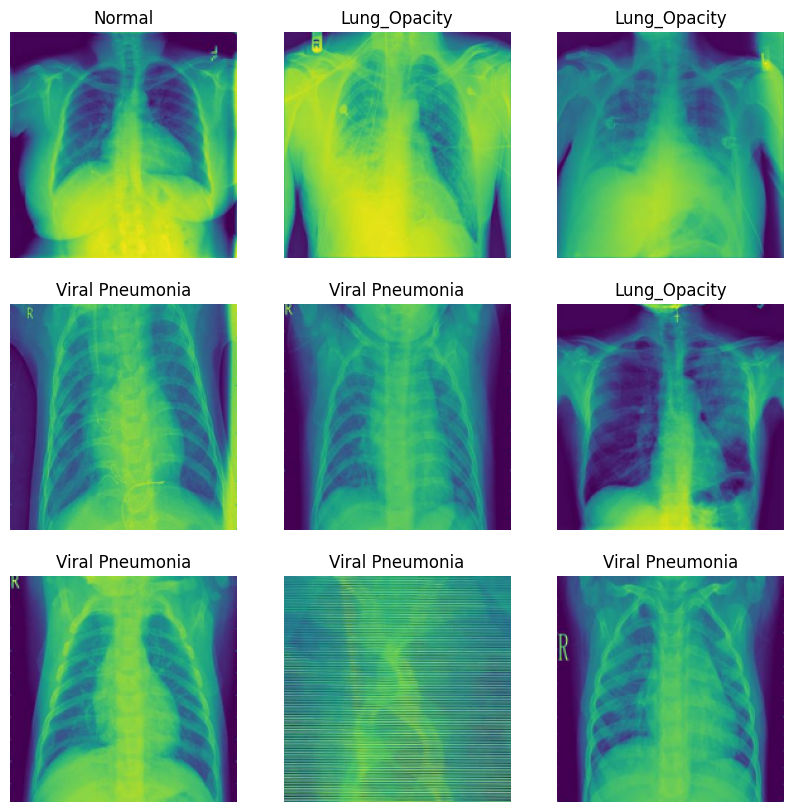

In [8]:
i=0
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(lungs_x_rays[labels[i]])
    plt.axis('off')

data augmentation_

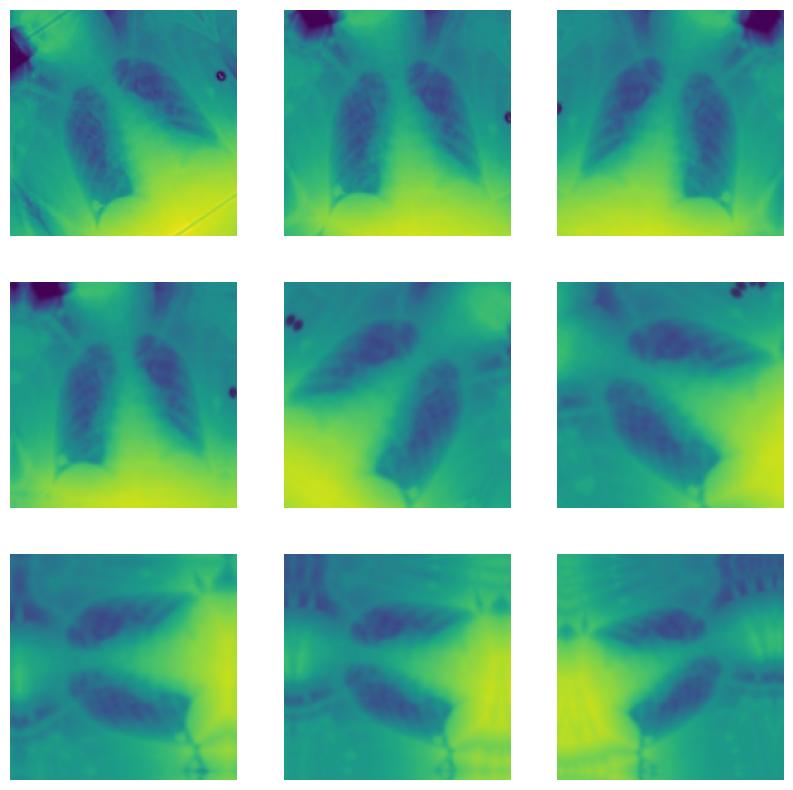

In [14]:
i=0
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    images=data_augmentation(images)
    plt.subplot(3,3,i+1)
    plt.imshow(images[0].numpy().astype('uint8'))
    #plt.title(rice_name[labels[i]])
    plt.axis('off')

In [15]:
model=Sequential([
                  data_augmentation,
                  layers.Rescaling(1./255),
                  layers.Conv2D(16,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Flatten(),
                  layers.Dense(128),
                  layers.Dense(len(lungs_x_rays))])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,027 (15.22 MB)

 Trainable params: 3,989,027 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history=model.fit(train_ds,epochs=25,validation_data=val_ds)

Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 33s 321ms/step - accuracy: 0.5623 - loss: 1.3621 - val_accuracy: 0.8061 - val_loss: 0.4629
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 300ms/step - accuracy: 0.7759 - loss: 0.5413 - val_accuracy: 0.8148 - val_loss: 0.4385
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step - accuracy: 0.7912 - loss: 0.5289 - val_accuracy: 0.8220 - val_loss: 0.4216
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - accuracy: 0.8044 - loss: 0.4657 - val_accuracy: 0.8495 - val_loss: 0.3919
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 297ms/step - accuracy: 0.8065 - loss: 0.4525 - val_accuracy: 0.8162 - val_loss: 0.4309
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 295ms/step - accuracy: 0.8113 - loss: 0.4486 - val_accuracy: 0.8177 - val_loss: 0.4493
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 303ms/step - accuracy: 0.8216 - loss: 0.4194 - val_accuracy: 0.8553 - val_loss: 0.3832
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 299ms/step - accuracy: 0.8290 - loss: 0.4214 - val_accu

In [19]:
model.save('lungs_x_ray.h5')